# Ordinal analysis of the MTurk Experiment

In [13]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pymc3 as pm
import theano.tensor as tt

from theano.compile.ops import as_op
from scipy.stats import norm
from matplotlib import gridspec
from matplotlib.patches import Rectangle
from IPython.display import Image
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

%matplotlib inline
plt.style.use('seaborn-white')

# sb.set_context(
#     "talk",
#     font_scale=1,
#     rc={
#         "lines.linewidth": 2.5,
#         "text.usetex": True,
#         "font.family": 'serif',
#         "font.serif": 'Palatino',
#         "font.size": 16
#     })
# from matplotlib import rc
# # rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica'], 'size': 16})
# # ## for Palatino and other serif fonts use:
# # rc('font', **{'family': 'serif', 'serif': ['Palatino'], 'size': 16})

# font = {'family': 'serif', 'serif': 'Palatino', 'weight': 'bold', 'size': 16}
# rc('font', **font)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Gill Sans MT']

# rc('text', usetex=True)

# sb.set_context(
#     "talk",
#     font_scale=1,
#     rc={
#         "lines.linewidth": 2.5,
#         "text.usetex": True,
#         "font.family": 'sans-serif',
#         "font.serif": 'Helvetica',
#         "weight": 'bold',
#         "font.size": 12
#     })
# from matplotlib import rc
# # rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica'], 'size': 16})
# # ## for Palatino and other serif fonts use:
# # rc('font', **{'family': 'serif', 'serif': ['Palatino'], 'size': 16})

# font = {'family': 'sans-serif', 'sans-serif': 'Helvetica', 'weight': 'bold', 'size': 12}
# rc('font', **font)
# rc('text', usetex=True)

In [20]:
rcParams?

# Data

In [2]:
# Using dtype 'category' for Y
df = pd.read_csv(
    'data/all_item_output_926.csv',
    dtype={
        'y': 'int',
        'gesture': 'int',
        'dist': 'int',
        'shading': 'int',
        'cond': 'int',
        'comicleft': 'int'
    })
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 6 columns):
gesture      655 non-null int64
dist         655 non-null int64
shading      655 non-null int64
y            655 non-null int64
cond         655 non-null int64
comicleft    655 non-null int64
dtypes: int64(6)
memory usage: 30.8 KB


In [4]:
df['y'] = (df['y'] + 4).astype('category') # changing the range to 1-7
dfpos = df[df.cond==1]
dfneg = df[df.cond==0]

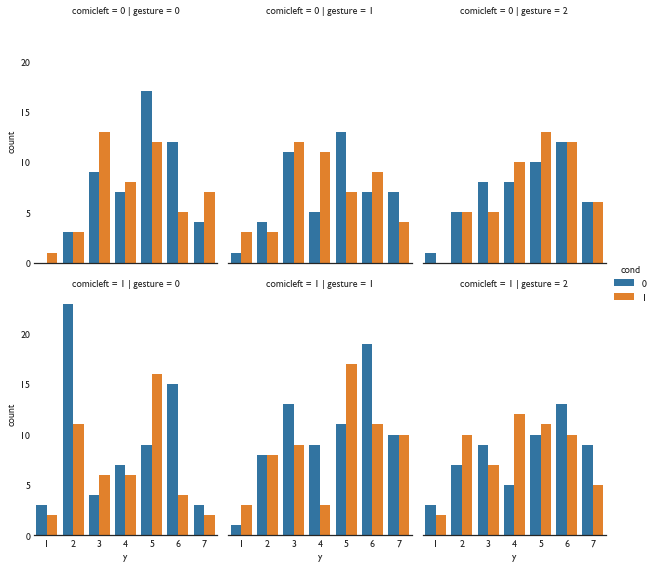

In [14]:
g = sb.factorplot(
    x="y",
    hue="cond",
    col="gesture",
    row="comicleft",
    data=df,
    kind="count",
    size=4,
    aspect=0.7)
g.despine(left=True)
g.savefig("condition-gesture-counts.pdf")

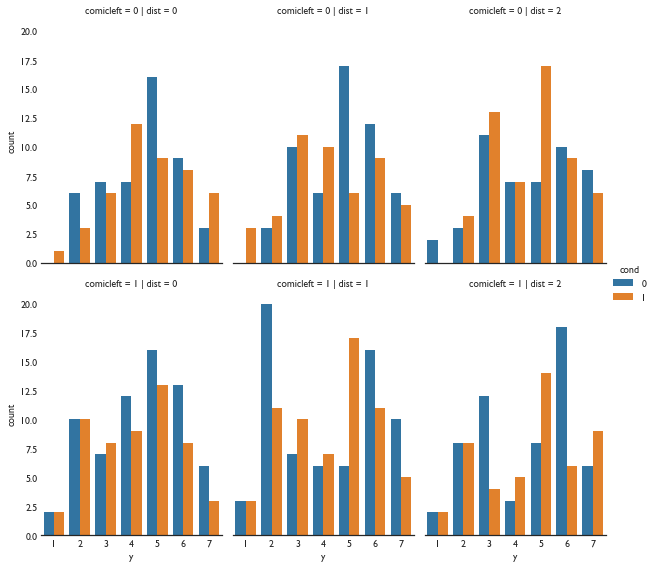

In [15]:
g = sb.factorplot(
    x="y",
    hue="cond",
    col="dist",
    row="comicleft",
    data=df,
    kind="count",
    size=4,
    aspect=0.7)
g.despine(left=True)
g.savefig("condition-dist-counts.pdf")

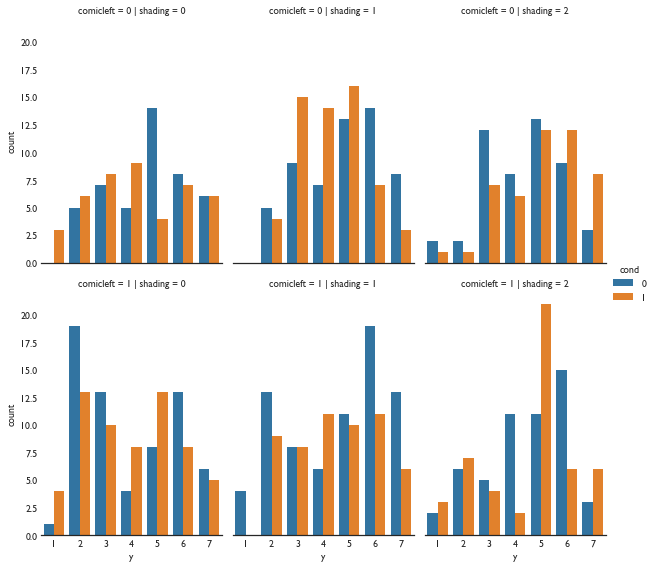

In [16]:
g = sb.factorplot(
    x="y",
    hue="cond",
    col="shading",
    row="comicleft",
    data=df,
    kind="count",
    size=4,
    aspect=0.7)
g.despine(left=True)
g.savefig("condition-shading-counts.pdf")

In [ ]:
X = df[['gesture', 'dist', 'shading', 'cond', 'comicleft']]
y_cat = (df['y']).astype('category')  # in range 1-7
nYlevels = y_cat.nunique()

In [ ]:
sd_X = X.std()
mean_X = X.mean()
zX = (X - mean_X)/sd_X
# zX = X # don't normalize because all values are between 0-2

In [ ]:
nYlevels4 = y_cat.nunique()

thresh4 = [k + 0.5
           for k in range(1, nYlevels4)]  # fixing the boundaries in our case
thresh_obs4 = np.ma.asarray(thresh4)
thresh_obs4[1:-1] = np.ma.masked

print('thresh4:\t{}'.format(thresh4))
print('thresh_obs4:\t{}'.format(thresh_obs4))

In [ ]:
@as_op(itypes=[tt.dvector, tt.dvector, tt.dscalar], otypes=[tt.dmatrix])
def outcome_probabilities(theta, mu, sigma):
    out = np.empty((mu.size, nYlevels4))
    n = norm(loc=mu, scale=sigma)
    out[:, 0] = n.cdf(theta[0])
    out[:, 1] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[1]) - n.cdf(theta[0])], axis=0)
    out[:, 2] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[2]) - n.cdf(theta[1])], axis=0)
    out[:, 3] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[3]) - n.cdf(theta[2])], axis=0)
    out[:, 4] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[4]) - n.cdf(theta[3])], axis=0)
    out[:, 5] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[5]) - n.cdf(theta[4])], axis=0)
    out[:, 6] = 1 - n.cdf(theta[5])
    return out


with pm.Model() as ordinal_model_multi_metric:

    theta = pm.Normal(
        'theta',
        mu=thresh4,
        tau=np.repeat(1 / 2**2, len(thresh4)),
        shape=len(thresh4),
        observed=thresh_obs4,
        testval=thresh4)

    # all coefficients should center at 0.0 because outocme 'y' is symmetric [-3,3]
    zbeta0 = pm.Normal('zbeta0', mu=(1 + nYlevels4) / 2, tau=1 / nYlevels4**2)
    zbeta = pm.Normal('zbeta', mu=0.0, tau=1 / nYlevels4**2, shape=X.shape[1])
    mu = pm.Deterministic('mu', zbeta0 + pm.math.dot(zbeta, zX.T))
    zsigma = pm.Uniform('zsigma', nYlevels4 / 1000.0, nYlevels4 * 10.0)

    pr = outcome_probabilities(theta, mu, zsigma)

    y = pm.Categorical('Y_obs', pr, observed=y_cat.cat.codes)

In [ ]:
with ordinal_model_multi_metric:
    step1 = pm.Metropolis()
    trace4 = pm.sample(10000, step=step1)

In [ ]:
z = trace4['mu']
z.shape

In [ ]:
burned_trace = trace4 # pymc3.1 discards the first 500 samples
# pm.traceplot(burned_trace);

NRows = 5  # change based on the number of parameters
NCols = 2
sb.set_style("white")
fig, axs = sb.mpl.pyplot.subplots(NRows,
                                  NCols)  #### change on changing parameters
fig.set_size_inches(8, 10)
# fig, axs = sb.plt.subplots(5, 2) #### change on changing parameters
# fig.set_size_inches(12, 12)
pm.plots.traceplot(
    trace=burned_trace,
    #     varnames=['theta_missing', 'zbeta0', 'zbeta', 'mu', 'zsigma'],
    #     lines={
    #         'b0': (burned_trace['b0']).mean(),
    #         'b1': (burned_trace['b1']).mean(),
    #         'b2': (burned_trace['b2']).mean(),
    #         'b3': (burned_trace['b3']).mean(),
    #         'b4': (burned_trace['b4']).mean(),
    #     }
    ax=axs)
axs[0, 0].set_title(r"$\theta$")
axs[0, 1].set_title(r"$\theta$")
axs[1, 0].set_title(r"$\beta_0$")
axs[1, 1].set_title(r"$\beta_1$")
axs[2, 0].set_title(r"$\beta_{1-5}$")
axs[2, 1].set_title(r"$\beta_{1-5}$")
axs[3, 0].set_title(r"$\mu$")
axs[3, 1].set_title(r"$\mu$")
axs[4, 0].set_title(r"$\sigma$")
axs[4, 1].set_title(r"$\sigma$")
axs[1, 0].xaxis.set_major_locator(plt.MaxNLocator(3))
axs[3, 0].xaxis.set_major_locator(plt.MaxNLocator(6))
axs[4, 0].xaxis.set_major_locator(plt.MaxNLocator(6))
for i in range(NRows):
    for j in range(NCols):
        z = axs[i, j]
        z.set_xlabel("")  # no individual labels
        z.set_ylabel("")
        z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        z.tick_params(
            direction='in', length=6, width=2, colors='k', which='major')
        z.tick_params(
            direction='in', length=4, width=1, colors='k', which='minor')
        z.xaxis.set_ticks_position('bottom')
        z.yaxis.set_ticks_position('left')
        z.minorticks_on()
        

fig.tight_layout()
fig.savefig("posterior plots.pdf")

In [ ]:
pm.diagnostics.gelman_rubin(trace4)

In [ ]:
burnin = 500
# Convert parameters to original scale
beta = trace4['zbeta'] / sd_X.as_matrix()
beta0 = trace4['zbeta0'] - np.sum(
    trace4['zbeta'] * mean_X.as_matrix() / sd_X.as_matrix(), axis=1)
sigma = trace4['zsigma']

sigma = trace4['zsigma']
mu = trace4['mu']
mu_mean = np.mean(mu, axis=1)

# compute the effect size
center = 4
n_m = (mu_mean - center) / sigma

NRows = 1  # change based on the number of parameters
NCols = 6
sb.set_style("white")
fig, axs = sb.mpl.pyplot.subplots(NRows,
                                  NCols)  #### change on changing parameters
fig.set_size_inches(NCols * 2, 2)

# Plot posteriors
pm.plot_posterior(
    beta0,
    point_estimate='mean',
    kde_plot='True',
    color='0.75',
    ax=axs[0],
    text_size=12)
pm.plot_posterior(
    beta[:, 0],
    point_estimate='mean',
    kde_plot='True',
    color='0.75',
    ax=axs[1],
    text_size=12)
pm.plot_posterior(
    beta[:, 1],
    point_estimate='mean',
    kde_plot='True',
    color='0.75',
    ax=axs[2],
    text_size=12)
pm.plot_posterior(
    beta[:, 2],
    point_estimate='mean',
    kde_plot='True',
    color='0.75',
    ax=axs[3],
    text_size=12)
pm.plot_posterior(
    beta[:, 3],
    point_estimate='mean',
    kde_plot='True',
    color='0.75',
    ax=axs[4],
    text_size=12)
pm.plot_posterior(
    beta[:, 4],
    point_estimate='mean',
    kde_plot='True',
    color='0.75',
    ax=axs[5],
    text_size=12)

beta_vars = [
    'intercept', 'gesture', 'distance', 'shading', 'framing condition',
    'comic position'
]
for j in range(NCols):
    z = axs[j]
    #     z.set_xlabel("") # no individual labels
    #     z.set_ylabel("")
    s = "$\\beta_{{{0}}}$".format(j)
    z.set_title(s)
    if j == 0:
        z.set_xlim([3, 5])
    else:
        z.set_xlim([-0.5, 0.5])
   
    z.set_xlabel("{0}".format(beta_vars[j]))
    z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
    z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
    z.xaxis.set_ticks_position('bottom')
    z.yaxis.set_ticks_position('left')
    z.minorticks_on()

fig.tight_layout()

fig.savefig("beta_values.pdf")

fig2, axs2 = sb.mpl.pyplot.subplots(1, 2)  #### change on changing parameters
fig2.set_size_inches(4, 2)

pm.plot_posterior(
    mu_mean,
    point_estimate='mean',
    kde_plot='True',
    color='0.75',
    ax=axs2[0],
    text_size=12)
pm.plot_posterior(
    n_m,
    point_estimate='mean',
    kde_plot='True',
    color='0.75',
    ax=axs2[1],
    text_size=12)

axs2[0].set_title(r'$\mu$')
axs2[0].set_xlim([4,5])

axs2[1].set_title(r"Effect Size")
axs2[1].set_xlim([0,0.5])

axs2[0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[0].tick_params(direction='in', length=6, width=2, colors='k', which='major')
axs2[0].tick_params(direction='in', length=4, width=1, colors='k', which='minor')
axs2[0].xaxis.set_ticks_position('bottom')
axs2[0].yaxis.set_ticks_position('left')
axs2[0].minorticks_on()

axs2[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[1].tick_params(direction='in', length=6, width=2, colors='k', which='major')
axs2[1].tick_params(direction='in', length=4, width=1, colors='k', which='minor')
axs2[1].xaxis.set_ticks_position('bottom')
axs2[1].yaxis.set_ticks_position('left')
axs2[1].minorticks_on()

fig2.tight_layout()
fig2.savefig("mean_effect.pdf")

# for title, label, ax in zip(['Intercept', 'Year', 'Length'],
#                             [r'$\beta_{0}$', r'$\beta_{1}$', r'$\beta_{2}$'],
#                             [ax2, ax3, ax4]):
#     ax.set_title(title, fontdict=f_dict)
#     ax.set_xlabel(label, fontdict=f_dict)

# Color v. No Color

## data

In [60]:
# Using dtype 'category' for Y
df_color = pd.read_csv(
    'data/color_data_0330.csv',
    dtype={
        'y': 'int',
        'color': 'int',
        'color_position': 'int',
        'cond': 'int'
    }
)

In [61]:
df_color

,color,color_position,cond,y
0,1,0,1,-2
1,1,0,1,0
2,1,0,1,-2
3,1,0,1,0
4,1,0,1,0
5,1,0,1,-1
6,1,0,1,0
7,1,0,1,0
8,1,0,1,1
9,1,0,1,-2


In [49]:
df_color.columns = ['color', 'location', 'condition', 'y']

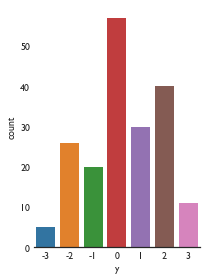

In [36]:
g_color = sb.factorplot(
    x="y",
#     hue="condition",
#     col="condition",
#     row="location",
    data=df_color,
    kind="count",
    size=4,
    aspect=0.7)
g_color.despine(left=True)
g_color.savefig("effects_of_color.pdf")

## Bayesian analysis of color

In [50]:
X = df_color[['color', 'location', 'condition']]
df_color['y'] = (df_color['y'] + 4).astype('category') # changing the range to 1-7
y_cat = (df_color['y']).astype('category')  # in range 1-7
nYlevels = y_cat.nunique()

In [63]:
X.shape

(189, 3)

In [51]:
sd_X = X.std()
mean_X = X.mean()
zX = (X - mean_X)/sd_X

In [52]:
nYlevels4 = y_cat.nunique()

thresh4 = [k + 0.5
           for k in range(1, nYlevels4)]  # fixing the boundaries in our case
thresh_obs4 = np.ma.asarray(thresh4)
thresh_obs4[1:-1] = np.ma.masked

print('thresh4:\t{}'.format(thresh4))
print('thresh_obs4:\t{}'.format(thresh_obs4))

thresh4:	[1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
thresh_obs4:	[1.5 -- -- -- -- 6.5]


In [53]:
@as_op(itypes=[tt.dvector, tt.dvector, tt.dscalar], otypes=[tt.dmatrix])
def outcome_probabilities(theta, mu, sigma):
    out = np.empty((mu.size, nYlevels4))
    n = norm(loc=mu, scale=sigma)
    out[:, 0] = n.cdf(theta[0])
    out[:, 1] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[1]) - n.cdf(theta[0])], axis=0)
    out[:, 2] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[2]) - n.cdf(theta[1])], axis=0)
    out[:, 3] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[3]) - n.cdf(theta[2])], axis=0)
    out[:, 4] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[4]) - n.cdf(theta[3])], axis=0)
    out[:, 5] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[5]) - n.cdf(theta[4])], axis=0)
    out[:, 6] = 1 - n.cdf(theta[5])
    return out


with pm.Model() as ordinal_model_color:

    theta = pm.Normal(
        'theta',
        mu=thresh4,
        tau=np.repeat(1 / 2**2, len(thresh4)),
        shape=len(thresh4),
        observed=thresh_obs4,
        testval=thresh4)

    # all coefficients should center at 0.0 because outocme 'y' is symmetric [-3,3]
    zbeta0 = pm.Normal('zbeta0', mu=(1 + nYlevels4) / 2, tau=1 / nYlevels4**2)
    zbeta = pm.Normal('zbeta', mu=0.0, tau=1 / nYlevels4**2, shape=X.shape[1])
    mu = pm.Deterministic('mu', zbeta0 + pm.math.dot(zbeta, zX.T))
    zsigma = pm.Uniform('zsigma', nYlevels4 / 1000.0, nYlevels4 * 10.0)

    pr = outcome_probabilities(theta, mu, zsigma)

    y = pm.Categorical('Y_obs', pr, observed=y_cat.cat.codes)

In [64]:
with ordinal_model_color:
    step1 = pm.Metropolis()
    trace4 = pm.sample(10000, step=step1)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [zsigma_interval__]
>Metropolis: [zbeta]
>Metropolis: [zbeta0]
>Metropolis: [theta_missing]
100%|██████████| 10500/10500 [05:06<00:00, 34.21it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


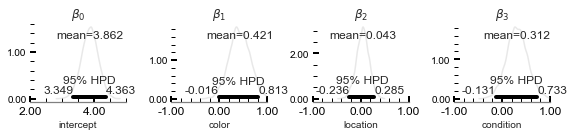

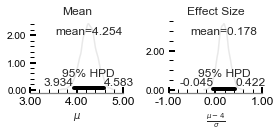

In [83]:
# Convert parameters to original scale
beta = trace4['zbeta'] / sd_X.as_matrix()
beta0 = trace4['zbeta0'] - np.sum(
    trace4['zbeta'] * mean_X.as_matrix() / sd_X.as_matrix(), axis=1)
sigma = trace4['zsigma']

sigma = trace4['zsigma']
mu = trace4['mu']
mu_mean = np.mean(mu, axis=1)

# compute the effect size
center = 4
n_m = (mu_mean - center) / sigma

NRows = 1  # change based on the number of parameters
NCols = X.shape[1] + 1 # adding 1 for \beta_0
sb.set_style("white")
fig, axs = sb.mpl.pyplot.subplots(NRows,
                                  NCols)  #### change on changing parameters
fig.set_size_inches(NCols * 2, 2)

# Plot posteriors
pm.plot_posterior(
    beta0,
    point_estimate='mean',
    kde_plot='True',
    color='0.75',
    ax=axs[0],
    text_size=12)
pm.plot_posterior(
    beta[:, 0],
    point_estimate='mean',
    kde_plot='True',
    color='0.75',
    ax=axs[1],
    text_size=12)
pm.plot_posterior(
    beta[:, 1],
    point_estimate='mean',
    kde_plot='True',
    color='0.75',
    ax=axs[2],
    text_size=12)
pm.plot_posterior(
    beta[:, 2],
    point_estimate='mean',
    kde_plot='True',
    color='0.75',
    ax=axs[3],
    text_size=12)


beta_vars = ['intercept', 'color', 'location', 'condition']
for j in range(NCols):
    z = axs[j]
    #     z.set_xlabel("") # no individual labels
    #     z.set_ylabel("")
    s = "$\\beta_{{{0}}}$".format(j)
    z.set_title(s)
    if j == 0:
        z.set_xlim([2, 5])
    else:
        z.set_xlim([-1, 1])
   
    z.set_xlabel("{0}".format(beta_vars[j]))
    z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
    z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
    z.xaxis.set_ticks_position('bottom')
    z.yaxis.set_ticks_position('left')
    z.minorticks_on()

fig.tight_layout()

fig.savefig("beta_values_color.pdf")

fig2, axs2 = sb.mpl.pyplot.subplots(1, 2)  #### change on changing parameters
fig2.set_size_inches(4, 2)

pm.plot_posterior(
    mu_mean,
    point_estimate='mean',
    kde_plot='True',
    color='0.75',
    ax=axs2[0],
    text_size=12)
pm.plot_posterior(
    n_m,
    point_estimate='mean',
    kde_plot='True',
    color='0.75',
    ax=axs2[1],
    text_size=12)

axs2[0].set_title(r"Mean")
axs2[0].set_xlim([3,5])
axs2[0].set_xlabel(r'$\mu$')

axs2[1].set_title(r"Effect Size")
axs2[1].set_xlim([-1,1])
axs2[1].set_xlabel(r'$\frac{\mu-4}{\sigma}$')

axs2[0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[0].tick_params(direction='in', length=6, width=2, colors='k', which='major')
axs2[0].tick_params(direction='in', length=4, width=1, colors='k', which='minor')
axs2[0].xaxis.set_ticks_position('bottom')
axs2[0].yaxis.set_ticks_position('left')
axs2[0].minorticks_on()

axs2[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[1].tick_params(direction='in', length=6, width=2, colors='k', which='major')
axs2[1].tick_params(direction='in', length=4, width=1, colors='k', which='minor')
axs2[1].xaxis.set_ticks_position('bottom')
axs2[1].yaxis.set_ticks_position('left')
axs2[1].minorticks_on()

fig2.tight_layout()
fig2.savefig("mean_effect_color.pdf")

# for title, label, ax in zip(['Intercept', 'Year', 'Length'],
#                             [r'$\beta_{0}$', r'$\beta_{1}$', r'$\beta_{2}$'],
#                             [ax2, ax3, ax4]):
#     ax.set_title(title, fontdict=f_dict)
#     ax.set_xlabel(label, fontdict=f_dict)